## Tutorial to call DIP-VAE algorithm via AIX360

The ability to infer abstract high-level concepts from raw sensory inputs is a key part of human intelligence. Developing models that recapitulate this ability is an important goal in AI research. A fundamental challenge in this respect is disentangling the underlying factors of variation that give rise to the observed data. 

Most real-world scenarios involve raw observations without any supervision about the generative factors. For such data, we can rely on latent generative models such as variational autoencoder (VAE) [1] that aim to maximize the likelihood of generating new examples that match the observed data. 

For inferring disentangled factors, inferred prior or expected variational posterior should be factorizable along its dimensions. DIP-VAE [2] adopts a simple yet effective approach of matching the moments of the two distributions. Matching the covariance of the two distributions will amount to decorrelating the dimensions of the inferred prior.

In this notebook, we demonstrate the use of DIP-VAE model for unsupervised learning of disentangled hidden factors from a large pool of unlabeled observations using the Fashion-MNIST dataset.

[1] Diederik P Kingma and Max Welling. Auto-encoding variational Bayes. ICLR, 2014.

[2] Kumar, A., Sattigeri, P., and Balakrishnan, A. Variational inference of disentangled latent concepts from unlabeled observations. ICLR, 2018.


#### Import statements

In [1]:
import sys
sys.path.append("../../")

In [2]:
from aix360.datasets.fashion_mnist_dataset import FMnistDataset
from aix360.algorithms.dipvae import DIPVAEExplainer

import torch
import numpy as np
import argparse

import matplotlib.pyplot as plt
import numpy as np

#### Load Fashion MNIST data

In [3]:
dataset_obj = FMnistDataset()

In [4]:
cuda_available = torch.cuda.is_available()
print("CUDA: {}".format(cuda_available))

CUDA: False


## Train baseline DIPVAE Explainer model

In the next cell we will set the various options to train the DIP-VAE model. First of all, DIP-VAE Explaniner model support the baseline VAE model and the two modes of DIP-VAE - i and ii (See [1] for the differences). 

Next, we will set the architecture parameters including activation_type, number of hidden nodes and the latent dimensions. The default implemenetations containing fully connected encoders and decoders. A user defined model can be specified as dipvaeii_args.model = 'user-defined' and passed to the fit function.

The rest of the parameters include number of epochs to train and the hyperparameters for the DIP-VAE regularizer. 

In [5]:
dipvaeii_args = argparse.Namespace()

dipvaeii_args.model = 'dipvae-ii'

dipvaeii_args.activation_type = 'relu'
dipvaeii_args.num_nodes =  1200
dipvaeii_args.latent_dim = 10
dipvaeii_args.num_gen_layers = 3
dipvaeii_args.num_inference_layers = 2

dipvaeii_args.step_size = 0.001
dipvaeii_args.num_epochs = 5
dipvaeii_args.lambda_diag_factor = 10.0
dipvaeii_args.lambda_offdiag = 0.001

dipvaeii_args.seed = 0

Next, we initialize the DIPVAE explainer with model arguments.

In [6]:
dipvaeii_explainer = DIPVAEExplainer(model_args=dipvaeii_args, dataset=dataset_obj, cuda_available=cuda_available)

The fit function is used to train the model.

In [7]:
dipvaeii_explainer.fit()

Epoch 0 | ELBO -71.01805877685547
Epoch 1 | ELBO -57.881744384765625
Epoch 2 | ELBO -56.25209045410156
Epoch 3 | ELBO -55.15901184082031
Epoch 4 | ELBO -54.62912368774414


[tensor(-71.0181, grad_fn=<DivBackward0>),
 tensor(-57.8817, grad_fn=<DivBackward0>),
 tensor(-56.2521, grad_fn=<DivBackward0>),
 tensor(-55.1590, grad_fn=<DivBackward0>),
 tensor(-54.6291, grad_fn=<DivBackward0>)]

Let us visualize the reconstruction generated by the training model.

In [13]:
%matplotlib inline

In [14]:
def convert_and_reshape(x):
    return x.cpu().data.numpy().reshape([-1] + dataset_obj.data_dims)

def plot_reconstructions(dataset_obj, trained_net, input_images, image_id_to_plot=0):
        
    z_sample, _, _ = trained_net.encode(input_images)
    print(z_sample[image_id_to_plot])
    recons = trained_net.decode(z_sample)
    
    input_images_numpy = convert_and_reshape(input_images)
    recons_numpy = convert_and_reshape(recons)
    
    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(input_images_numpy[image_id_to_plot,:,:,0], cmap="gray")
    axarr[1].imshow(recons_numpy[image_id_to_plot,:,:,0], cmap="gray")

tensor([-0.1243, -1.6455,  0.1885, -0.4972,  1.2636,  0.4919, -0.2897,  0.1524,
        -1.6435, -0.5117], grad_fn=<SelectBackward>)


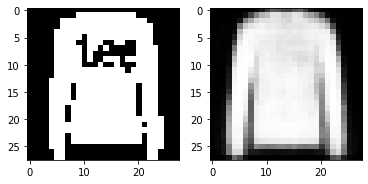

In [15]:
for x, _ in dataset_obj.next_test_batch():
        input_images = x.squeeze().view(-1, np.prod(dataset_obj.data_dims))
        break

plot_reconstructions(dataset_obj, dipvaeii_explainer.net, input_images, image_id_to_plot=1)

## Latent traversal to visualize disentaglement

Below we show decoder's output for latent traversals (varying a single latent at a time while keeping others fixed). Ideally, each dimension should contral a generative factor or be switched off.  

In [16]:
def plot_latent_traversal(explainer, input_images, args, image_id_to_plot=0, num_sweeps=15, max_abs_edit_value=10.0):
    edit_dim_values = np.linspace(-1.0 *max_abs_edit_value, max_abs_edit_value, num_sweeps)

    f, axarr = plt.subplots(args.latent_dim, len(edit_dim_values), sharex=True, sharey=True)
    f.set_size_inches(10, 10* args.latent_dim / len(edit_dim_values))

    for j in range(len(edit_dim_values)):
        for i in range(args.latent_dim):
            edited_images = convert_and_reshape(explainer.explain(input_images=input_images,
                             edit_dim_id = i,
                             edit_dim_value = edit_dim_values[j],edit_z_sample=True))
            axarr[i][j].imshow(edited_images[image_id_to_plot,:,:,0], cmap="gray", aspect='auto')
            #axarr[j][i].axis('off')
            if i == len(axarr) - 1:
                axarr[i][j].set_xlabel("z:" + str(np.round(edit_dim_values[j], 1)))
            if j == 0:
                axarr[i][j].set_ylabel("l:" + str(i))
            axarr[i][j].set_yticks([])
            axarr[i][j].set_xticks([])
    plt.subplots_adjust(hspace=0, wspace=0)
            

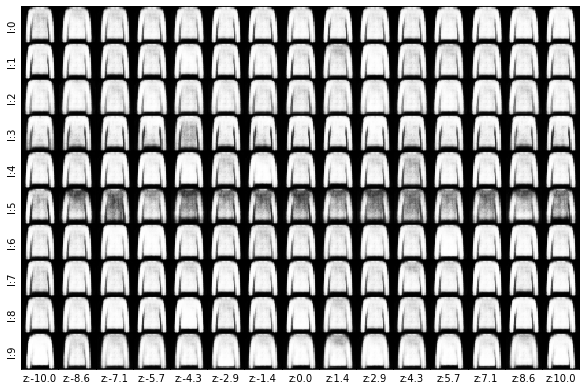

In [17]:
plot_latent_traversal(dipvaeii_explainer, input_images, dipvaeii_args, image_id_to_plot=1)